In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import torch
import pyreadr
import requests
import urllib.request
import math
import pandas as pd 
import random
import numpy as np
from sklearn.datasets import load_iris 
from scipy.ndimage import gaussian_filter
from sklearn import preprocessing
from sklearn import utils
import seaborn as sns
from sklearn.impute import KNNImputer

    
import statistics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn import svm
from torchvision import datasets, transforms
from sklearn import neighbors
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [2]:
#IMPORT OF DATA AND MIN MAX SCALING OF DATA
P2=pd.read_csv('Plant2_summed_dataset.csv',na_values='?')
P2.drop(['Unnamed: 0'],inplace=True,axis=1)

feature_names=['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
X = P2[feature_names]
y = P2['AC_POWER']
scaler=MinMaxScaler()
scaler.fit(X)
X=pd.DataFrame(scaler.transform(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=6/34, shuffle=False)
display(P2)

,DATE_TIME,AC_POWER,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,0.0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,0.0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,0.0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,0.0,26.596148,25.088210,0.0
...,...,...,...,...,...
3254,2020-06-17 22:45:00,0.0,23.511703,22.856201,0.0
3255,2020-06-17 23:00:00,0.0,23.482282,22.744190,0.0
3256,2020-06-17 23:15:00,0.0,23.354743,22.492245,0.0
3257,2020-06-17 23:30:00,0.0,23.291048,22.373909,0.0


C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,DATE_TIME,AC_POWER,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,0.0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,0.0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,0.0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,0.0,26.596148,25.088210,0.0
...,...,...,...,...,...
3254,2020-06-17 22:45:00,0.0,23.511703,22.856201,0.0
3255,2020-06-17 23:00:00,0.0,23.482282,22.744190,0.0
3256,2020-06-17 23:15:00,0.0,23.354743,22.492245,0.0
3257,2020-06-17 23:30:00,0.0,23.291048,22.373909,0.0


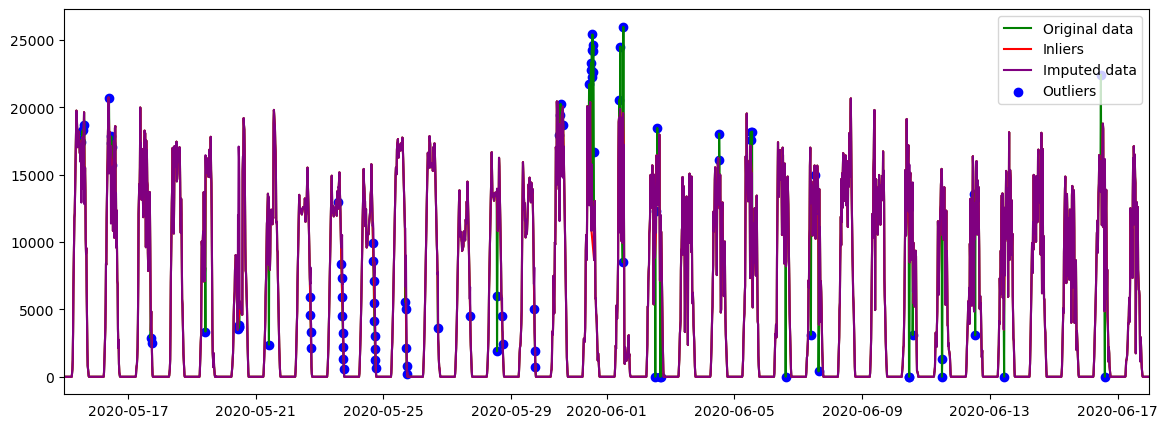

In [3]:
#OUTLIER DETECTION
P2_det=P2.copy()
anomaly_inputs=['AC_POWER','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']
#IN IsolationForest, adjust contamination [0-0,5], indicates the percentage of expected outliers.
#Use plot at the end of this code block to check if the outliers are actually identified
model_IF = IsolationForest(contamination=0.03, random_state=42)
model_IF.fit(P2_det[anomaly_inputs])
P2_det['anomaly_scores'] = model_IF.decision_function(P2_det[anomaly_inputs])
P2_det['anomaly'] = model_IF.predict(P2_det[anomaly_inputs])


#OUTLIER INDEXES
out_index=np.asarray(np.where(P2_det['anomaly']==-1)[0]).astype(int)
#INLIER INDEXES
in_index=np.asarray(np.where(P2_det['anomaly']==1)[0]).astype(int)

#MAKING COPY TO MAKE CHANGES TO
P2_imp=pd.DataFrame(P2.copy())

#REPLACING OUTLIERS WITH NaN
P2_imp.iloc[out_index,1]=np.nan
P2_imp['DATE_TIME']=pd.to_datetime(P2_imp['DATE_TIME'])

#SANITY CHECKS
display(P2_imp)# SHOW DATAFRAME


#KNN IMPUTATION
imputer = KNNImputer(n_neighbors=3)
P2_imp.iloc[:,1:]=imputer.fit_transform(P2_imp.iloc[:,1:])


#print('missing values:',P2_imp.isna().sum())


plt.figure(figsize=(14,5))
start, end= 0,(len(P2)-1)
plt.plot(pd.to_datetime(P2_det.iloc[:,0]),P2_det.iloc[:,1],color='green')#ORIGINAL DATA
plt.plot(pd.to_datetime(P2_det.iloc[in_index,0]),P2_det.iloc[in_index,1],color='red')#INLIERS
plt.plot(pd.to_datetime(P2_det.iloc[:,0]),P2_imp.iloc[:,1],color='purple')#IMPUTED DATA
plt.scatter(pd.to_datetime(P2_det.iloc[out_index,0]),P2_det.iloc[out_index,1],color='blue')#OUTLIERS
plt.xlim([pd.to_datetime(P2_det.iloc[start,0]),pd.to_datetime(P2_det.iloc[end,0])])
plt.legend(['Original data','Inliers','Imputed data','Outliers'])
plt.show()

#USE THIS DATA INSTEAD IN THE REST OF THE CODE

feature_names=['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
X_imp = P2_imp[feature_names]
y_imp = P2_imp['AC_POWER']
scaler1=MinMaxScaler()
scaler1.fit(X_imp)
X_imp=pd.DataFrame(scaler.transform(X_imp))
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y_imp, test_size=6/34, shuffle=False)
#display(P2_imp)



In [4]:
# PARAMETER SEARCH - ANDI
param_grid = {'n_neighbors':range(1,200) } 
tscv = TimeSeriesSplit(n_splits=7)
knn = neighbors.KNeighborsRegressor(n_jobs=-1)
grid = GridSearchCV(knn, param_grid=param_grid, cv=tscv, return_train_score=True, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.score(X_test, y_test))

{'n_neighbors': 153}
0.8782215565775071


C:\Users\Jacob\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
C:\Users\Jacob\AppData\Local\Temp\ipykernel_1168\2790779434.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.fill_between(results.param_n_neighbors.astype(np.int),
C:\Users\Jacob\AppData\Local\Temp\ipykernel_1168\2790779434.py:11: DeprecationWarning: `np.int` is a deprecated a

(0.0, 200.0)

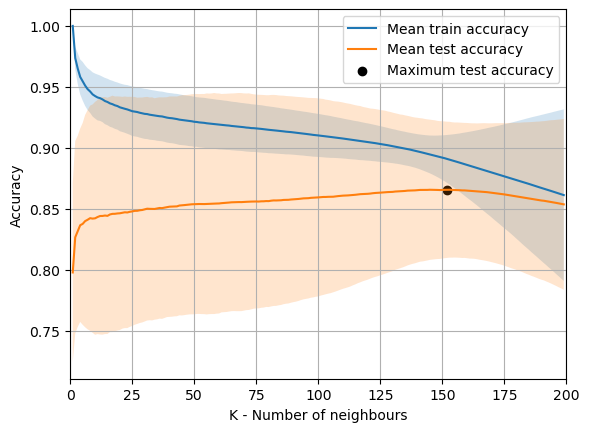

In [5]:
#VISUALIZATION OF PARAMETER SEARCH - ANDI
results = pd.DataFrame(grid.cv_results_)


results.plot('param_n_neighbors', 'mean_train_score')
results.plot('param_n_neighbors', 'mean_test_score', ax=plt.gca()) # Tror "validation" score, but called "test" score; like Rahman has written.
plt.scatter(np.where(results['mean_test_score']==max(results['mean_test_score']))[0],max(results['mean_test_score']),marker='o',color='black')
plt.fill_between(results.param_n_neighbors.astype(np.int),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_n_neighbors.astype(np.int),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)

plt.legend(['Mean train accuracy','Mean test accuracy','Maximum test accuracy'])
plt.xlabel('K - Number of neighbours')
plt.ylabel('Accuracy')
plt.grid()
plt.xlim([0,200])

In [6]:
#ALSO PARAMETER SEARCH
scores,std=[],[]
train_scores = []
for k in range(1,200):
    knn = neighbors.KNeighborsRegressor(n_jobs=-1,n_neighbors=k)
    scores.append(np.mean(cross_val_score(knn,X_train,y_train,n_jobs=-1,cv=tscv)))
    std.append(statistics.stdev(cross_val_score(knn,X_train,y_train,n_jobs=-1,cv=tscv)))
    knn.fit(X_train,y_train)
    train_scores.append(knn.score(X_train,y_train))
scores=np.asarray(scores)
std=np.asarray(std)
train_scores=np.asarray(train_scores)
    

In [7]:
#print('Scores:\n',scores)
#print('Standard deviation:\n',std)
#print(np.where(scores==max(scores)))
#print('training score:\n',train_scores)

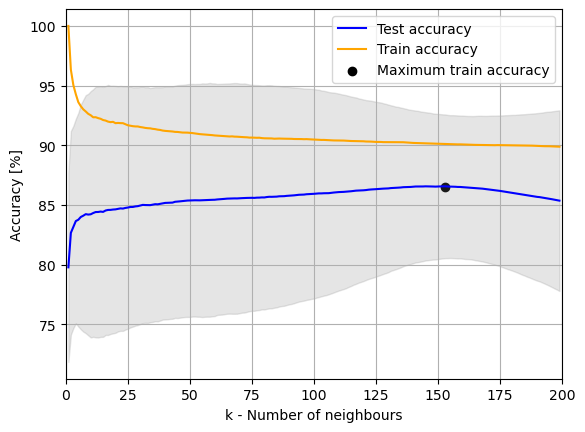

In [8]:
#PLOT OF PARAMETER SEARCH
plt.plot(range(1,200),np.multiply(scores,100),color='b')
plt.plot(range(1,200),np.multiply(train_scores,100),color='orange')
plt.scatter(153,scores[153]*100,marker='o',color='black')
plt.fill_between(range(1,200), np.multiply(scores,100) - np.multiply(std,100), np.multiply(scores,100) + np.multiply(std,100),
                 color='gray', alpha=0.2)
plt.grid()
plt.legend(['Test accuracy','Train accuracy','Maximum train accuracy'])
plt.xlabel('k - Number of neighbours')
plt.ylabel('Accuracy [%]')
plt.xlim([0,200])
plt.show()

Score 0.8782215565775071


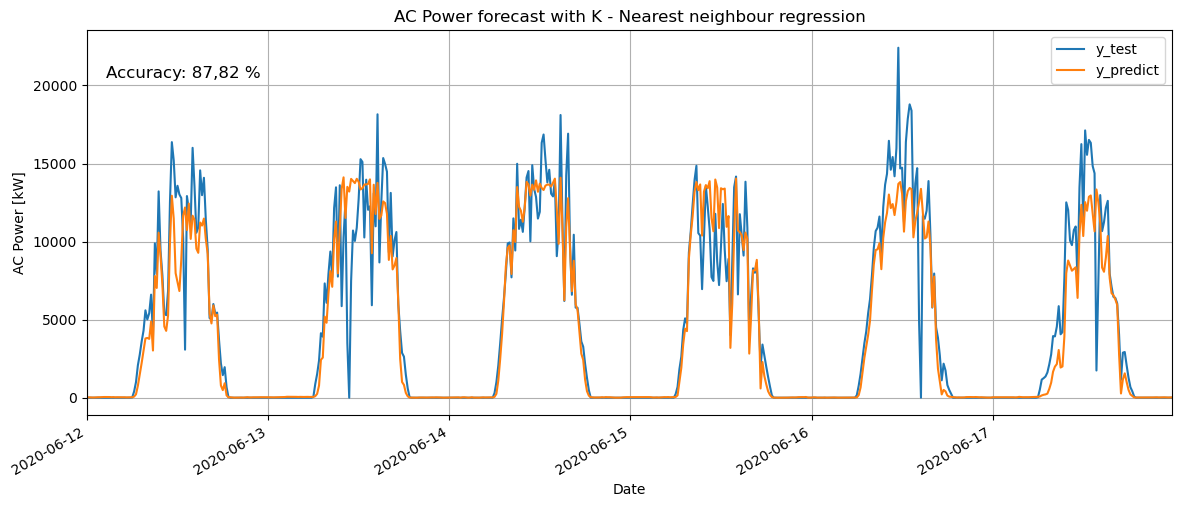

In [9]:
#PLOT OF FORECAST
knn2=neighbors.KNeighborsRegressor(n_jobs=-1,n_neighbors=153)
knn2.fit(X_train,y_train)
predicted=knn2.predict(X_test)

print('Score',knn2.score(X_test,y_test))

#PLOT
plt.figure(figsize=(14,5))
plt.grid()
plt.plot(pd.to_datetime(P2['DATE_TIME'])[len(y_train):],y_test) #TEST DATA
plt.plot(pd.to_datetime(P2['DATE_TIME'])[len(y_train):],predicted) #PREDICTION OF y_test
plt.xticks(rotation=30, ha='right')
plt.xlim([pd.to_datetime(P2['DATE_TIME'])[len(y_train)], pd.to_datetime(P2['DATE_TIME'])[len(y_train)+len(y_test)-1]])
plt.xlabel('Date')
plt.ylabel('AC Power [kW]')
plt.legend(['y_test','y_predict'])
plt.title('AC Power forecast with K - Nearest neighbour regression')
plt.text(pd.to_datetime(P2['DATE_TIME'])[len(y_train)+10], 20500, 'Accuracy: 87,82 %', fontsize = 12)
plt.show()

In [10]:
print(pd.to_datetime(P2['DATE_TIME'])[len(y_train):])

2683   2020-06-12 00:00:00
2684   2020-06-12 00:15:00
2685   2020-06-12 00:30:00
2686   2020-06-12 00:45:00
2687   2020-06-12 01:00:00
               ...        
3254   2020-06-17 22:45:00
3255   2020-06-17 23:00:00
3256   2020-06-17 23:15:00
3257   2020-06-17 23:30:00
3258   2020-06-17 23:45:00
Name: DATE_TIME, Length: 576, dtype: datetime64[ns]
